In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
dataset_identifier = 'redwankarimsony/heart-disease-data'
dataset_path = kagglehub.dataset_download(dataset_identifier)
print(f"Dataset downloaded to: {dataset_path}")


Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded to: /kaggle/input/heart-disease-data


In [54]:
import os
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

if len(csv_files) > 0:
    csv_file_path = os.path.join(dataset_path, csv_files[0])
    df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print(f"No CSV file found in the directory: {dataset_path}")

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [55]:
print("Shape:", df.shape)
df.head()


Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [56]:
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

Missing Values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps   

/tmp/ipython-input-95881980.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num', data=df, palette="Set2")


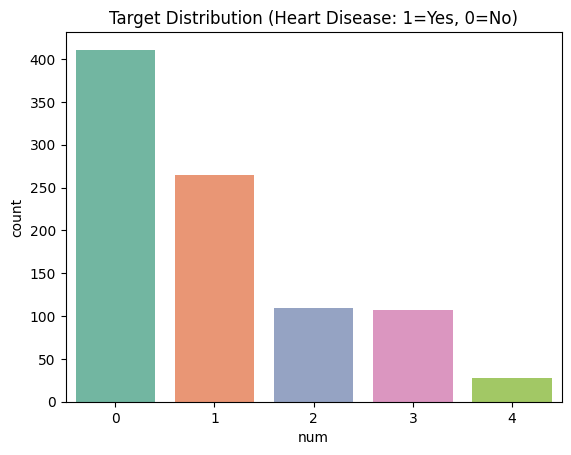

In [57]:
sns.countplot(x='num', data=df, palette="Set2")
plt.title("Target Distribution (Heart Disease: 1=Yes, 0=No)")
plt.show()


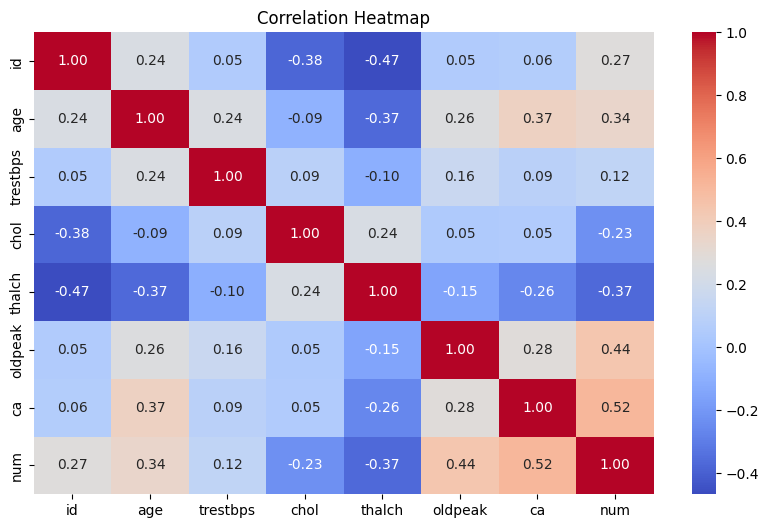

In [58]:
plt.figure(figsize=(10,6))
# Select only numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [59]:
X = df.drop('num', axis=1)
y = df['num']
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical Features: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [60]:
# drop rows if missing <5%
for col in numeric_cols:
    pct = df[col].isnull().mean()
    if 0 < pct < 0.05:
        df = df[df[col].notnull()]
# impute mediam for numeric
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median = df[col].median()
        df[col].fillna(median, inplace=True)

# impute mode for categorical
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)
print( "missing values" ,df.isnull().sum())




missing values id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


/tmp/ipython-input-2623300458.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
/tmp/ipython-input-2623300458.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [61]:
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [62]:
scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print("Train Shape:", X_train.shape, "Test Shape:", X_test.shape)

Train Shape: (736, 22) Test Shape: (184, 22)


In [64]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_imputed, y_train) # Use imputed data for training
y_pred_log = log_reg.predict(X_test_imputed) # Use imputed data for prediction
acc_log = accuracy_score(y_test, y_pred_log)

print("\n--- Logistic Regression ---")
print("Accuracy:", acc_log)
print(classification_report(y_test, y_pred_log))


--- Logistic Regression ---
Accuracy: 0.6141304347826086
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        82
           1       0.52      0.68      0.59        53
           2       0.25      0.09      0.13        22
           3       0.19      0.19      0.19        21
           4       0.00      0.00      0.00         6

    accuracy                           0.61       184
   macro avg       0.36      0.37      0.35       184
weighted avg       0.57      0.61      0.58       184



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("\n--- Random Forest ---")
print("Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf))



--- Random Forest ---
Accuracy: 0.6413043478260869
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.63      0.72      0.67        53
           2       0.20      0.14      0.16        22
           3       0.26      0.24      0.25        21
           4       0.00      0.00      0.00         6

    accuracy                           0.64       184
   macro avg       0.38      0.39      0.39       184
weighted avg       0.60      0.64      0.62       184



In [66]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("\n--- XGBoost ---")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Accuracy: 0.6304347826086957
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.67      0.64      0.65        53
           2       0.27      0.27      0.27        22
           3       0.22      0.29      0.25        21
           4       0.00      0.00      0.00         6

    accuracy                           0.63       184
   macro avg       0.41      0.41      0.41       184
weighted avg       0.64      0.63      0.63       184



In [67]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [acc_log, acc_rf, acc_xgb]
})

print("\nModel Comparison:\n", results)



Model Comparison:
                  Model  Accuracy
0  Logistic Regression  0.614130
1        Random Forest  0.641304
2              XGBoost  0.630435
